# Superconducting qubits: improving the performance of the cross resonance gate
**Increasing robustness against crosstalk**

BOULDER OPAL enables you to optimize controls to achieve a target operation on your quantum hardware. In this Application note, you'll find the steps needed to obtain robust control solutions for superconducting qubits coupled by a common transmission line. These controls exhibit increased robustness of the cross resonance gate (target) against noise that arises due to crosstalk. First, you'll learn to set up the system and to optimize the control pulses. You can then verify the accuracy and robustness of the optimized controls through simulation of the resulting time evolution, including crosstalk.

## Imports and initialization

In [1]:
import numpy as np
from qctrl import Qctrl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from qctrlvisualizer import plot_controls
from qctrlvisualizer import get_qctrl_style

qctrl = Qctrl()

plt.style.use(get_qctrl_style())

colors = {"Optimized": "#BF04DC", "Robust": "#680CE9", "Primitive": "k"}

## Creating a Q-CTRL cross resonance gate robust to crosstalk
Consider a system of two transmon qubits coupled by a common transmission line. Qubit 1 is defined as the control qubit, and qubit 2 is the target qubit. The control qubit is driven by the in-phase and quadrature microwave drive with a frequency that matches the target qubit frequency. In a frame rotating with the drive frequency and after applying the rotating wave approximation (RWA) the Hamiltonian is of the form:

$$ H = \hbar(\Delta + \epsilon)n_1+
\frac{\hbar\delta_1}{2} n_1(n_1 - 1)+
\hbar\epsilon n_2+
\frac{\hbar\delta_2}{2}n_2(n_2 - 1)+
\hbar g \left( b_1^\dagger b_2 + b_1 b_2^\dagger \right) +\frac{\hbar}{2}\left(\Omega(t)b_1^\dagger + \text{h.c.}\right)\,,$$

where $n_i$ and $b_i$ are the number and annihilation operators of the $i$th qubit, $\Delta=\omega_1-\omega_2$ is the detuning between the two qubits where $\omega_i$ is the frequency of the $i$th qubit, $\epsilon$ is the mismatch between the drive frequency and the target qubit frequency, $g$ is the effective coupling strength between the qubits, $\Omega$ is the drive modulus and $\delta_i$ is the anharmonicity of the $i$th qubit. The above Hamiltonian is valid when the coupling strength is small compared to the detuning between the two qubits, $\Delta\gg g$.

The target operation is the $\pi/2$ cross resonance gate which operates in the space of the two lowest levels:

$$U_{CR}\left(\frac{\pi}{2}\right)=\frac{1}{\sqrt{2}}\left(\mathbb{I}-i\sigma_z^{(1)}\sigma_x^{(2)}\right)=[ZX]^{1/2}.$$

Since the above operation is defined up to phase factors of the individual qubits, this may lead to a large infidelity. Consequently, a final (optimizable) phase shift on each qubit is introduced to overcome the infidelity inflation due to these phase factors.

This Application note addresses robustness to crosstalk. Crosstalk between the qubits leads to unwanted effects that may mimic the effect of noise. The crosstalk Hamiltonian has the form

$$
H_\text{ct}
  = c_\text{ct}
  \frac{\hbar\Omega(t)}{2}b_2^\dagger + \text{h.c.}\,,
$$ where $c_\text{ct}$ is the (complex) relative crosstalk.

In this section, you'll learn to optimize the implementation of the target gate under the effect of crosstalk. This is performed within the framework of the four-level approximation, where only the first four levels of each qubit are considered. Moreover, only up to three excitations overall are permitted, which further reduces the Hilbert space from $16$ states to $10$ states.

To set up the optimization, first define operators and constants.

In [2]:
Mega = 1e6
micro = 1e-6

# Constants in the lab frame
omega_1 = 5114 * 2 * np.pi  # MHz
omega_2 = 4914 * 2 * np.pi  # MHz
delta_1 = -330 * 2 * np.pi  # MHz
delta_2 = -330 * 2 * np.pi  # MHz
g = 3.8 * 2 * np.pi  # MHz
Delta = omega_1 - omega_2
epsilon = 0  # g**2/Delta

# Limits for drive amplitudes
epsilon_1_min = -2 * np.pi * 200  # MHz
epsilon_1_max = 2 * np.pi * 200  # MHz

Next, define the operators in the Hamiltonian and the target gate.

In [3]:
# Lowering operator
b = np.diag([1, np.sqrt(2), np.sqrt(3)], 1)
# Number operator
n = np.diag([0, 1, 2, 3])
# Projector onto the two lowest states
qubit_proj = np.diag([1, 1, 0, 0])

# Pauli operators
sigma_x = np.zeros(n.shape)
sigma_x[:2, :2] = np.array([[0, 1], [1, 0]])
sigma_y = np.zeros(n.shape, dtype=np.complex)
sigma_y[:2, :2] = 1j * np.array([[0, -1], [1, 0]])
sigma_z = np.zeros(n.shape)
sigma_z[:2, :2] = np.array([[1, 0], [0, -1]])

# Embedding the above single-qubit operators into the two-qubit system of dimension 16
b1 = np.kron(b, np.eye(4))
b2 = np.kron(np.eye(4), b)

n1 = np.kron(n, np.eye(4))
n2 = np.kron(np.eye(4), n)

proj = np.kron(qubit_proj, qubit_proj)

sigma1_x = np.kron(sigma_x, np.eye(4))
sigma2_x = np.kron(np.eye(4), sigma_x)

sigma1_y = np.kron(sigma_y, np.eye(4))
sigma2_y = np.kron(np.eye(4), sigma_y)

sigma1_z = np.kron(sigma_z, np.eye(4))
sigma2_z = np.kron(np.eye(4), sigma_z)

# Block-diagonal permutations
perm = np.argsort(np.diag(n1 + n2))
perm_trunc = perm[:10]
block_n = [np.where(np.diag(n1 + n2) == n)[0].tolist() for n in range(4)]

# Frame transformation HS = SD
hamiltonian_with_no_drives = (
    (Delta - delta_1 / 2 + epsilon) * n1[:, perm_trunc][perm_trunc, :]
    + (-delta_2 / 2 + epsilon) * n2[:, perm_trunc][perm_trunc, :]
    + delta_1 * np.matmul(n1, n1)[:, perm_trunc][perm_trunc, :] / 2
    + delta_2 * np.matmul(n2, n2)[:, perm_trunc][perm_trunc, :] / 2
    + g
    * (np.kron(b.T.conj(), b) + np.kron(b, b.T.conj()))[:, perm_trunc][perm_trunc, :]
)
S = np.eye(10)
base_index = 0
for i in block_n:
    inds = np.arange(base_index, base_index + len(i))
    eigenvalues, eigenvectors = np.linalg.eigh(
        hamiltonian_with_no_drives[:, inds][inds, :]
    )
    for k, j in enumerate(eigenvectors.T):
        ind = np.abs(np.abs(j) - 1.0).argmin()
        S[:, base_index + ind][inds] = j * np.sign(j[ind])
    base_index += len(i)

# The phase shift operators in the simulation/optimization frame
phase_shift_operator1 = (S.dot(sigma1_z[:, perm_trunc][perm_trunc, :] / 2)).dot(
    S.T.conj()
)
phase_shift_operator2 = (S.dot(sigma2_z[:, perm_trunc][perm_trunc, :] / 2)).dot(
    S.T.conj()
)

# Drive operators
drive_1x_operator = (b1.T.conj() + b1)[:, perm_trunc][perm_trunc, :] / 2
drive_1y_operator = 1j * (b1.T.conj() - b1)[:, perm_trunc][perm_trunc, :] / 2

# Crosstalk operators
drive_2x_operator = (b2.T.conj() + b2)[:, perm_trunc][perm_trunc, :] / 2
drive_2y_operator = 1j * (b2.T.conj() - b2)[:, perm_trunc][perm_trunc, :] / 2

# Target in the simulation/optimization frame
zx_half = S.dot(
    ((proj - 1j * np.kron(sigma_z, sigma_x)) / np.sqrt(2))[:, perm_trunc][perm_trunc, :]
).dot(S.T.conj())

### Creating control pulses

Next, define the optimization configuration and the control schemes: Primitive, Optimized and Robust.

In [4]:
# Optimization constraints
duration = 0.4  # us
crosstalk_constant = 0.1
segment_count_primitive = 1
segment_count_optimized = 200

pulse_durations_primitive = (
    np.ones([segment_count_primitive]) * duration / segment_count_primitive
)
pulse_durations_optimized = (
    np.ones([segment_count_optimized]) * duration / segment_count_optimized
)

# Gate schemes
gate_schemes = ["Primitive", "Optimized", "Robust"]

The optimization specification in the next cell involves several steps:
- create the (noiseless) Hamiltonian,
- create the noise operators,
- define the cost function to be minimized by the optimizer, which is the infidelity of the system's evolution,
- introduce the final (optimizable) phase shift on each qubit,
- compute the infidelity of the Hamiltonian with optimizable phase shifts.

The outputs are the optimized values of $\Omega(t)$ ($x$ and $y$ components) across the gate duration, the optimized phase shifts, and the infidelities with and without the phase shifts.

In [5]:
def scheme_optimization(primitive_flag, noise_flag, segment_count, optimization_count):
    with qctrl.create_graph() as graph:
        # Construct drive terms
        drive_1x = qctrl.operations.pwc_signal(
            values=qctrl.operations.bounded_optimization_variable(
                count=segment_count,
                lower_bound=epsilon_1_min,
                upper_bound=epsilon_1_max,
            ),
            duration=duration,
            name="drive_1x",
        )
        if primitive_flag:
            drive_1y = qctrl.operations.pwc_signal(
                values=np.zeros(segment_count), duration=duration, name="drive_1y"
            )
        else:
            drive_1y = qctrl.operations.pwc_signal(
                values=qctrl.operations.bounded_optimization_variable(
                    count=segment_count,
                    lower_bound=epsilon_1_min,
                    upper_bound=epsilon_1_max,
                ),
                duration=duration,
                name="drive_1y",
            )
        drive_1x_term = qctrl.operations.pwc_operator(
            signal=drive_1x, operator=drive_1x_operator
        )
        drive_1y_term = qctrl.operations.pwc_operator(
            signal=drive_1y, operator=drive_1y_operator
        )

        # Construct remaining Hamiltonian terms
        fixed_frequency_1_term = qctrl.operations.constant_pwc_operator(
            operator=(Delta - delta_1 / 2 + epsilon) * n1[:, perm_trunc][perm_trunc, :],
            duration=duration,
        )
        fixed_frequency_2_term = qctrl.operations.constant_pwc_operator(
            operator=(-delta_2 / 2 + epsilon) * n2[:, perm_trunc][perm_trunc, :],
            duration=duration,
        )
        fixed_anharmonicity_1_term = qctrl.operations.constant_pwc_operator(
            operator=delta_1 * np.matmul(n1, n1)[:, perm_trunc][perm_trunc, :] / 2,
            duration=duration,
        )
        fixed_anharmonicity_2_term = qctrl.operations.constant_pwc_operator(
            operator=delta_2 * np.matmul(n2, n2)[:, perm_trunc][perm_trunc, :] / 2,
            duration=duration,
        )
        fixed_coupling_term = qctrl.operations.constant_pwc_operator(
            operator=g
            * (np.kron(b.T.conj(), b) + np.kron(b, b.T.conj()))[:, perm_trunc][
                perm_trunc, :
            ],
            duration=duration,
        )
        hamiltonian = qctrl.operations.pwc_sum(
            [
                drive_1x_term,
                drive_1y_term,
                fixed_frequency_1_term,
                fixed_frequency_2_term,
                fixed_anharmonicity_1_term,
                fixed_anharmonicity_2_term,
                fixed_coupling_term,
            ]
        )

        # Create noise operators
        crosstalk_1x = qctrl.operations.pwc_operator(
            signal=drive_1x, operator=crosstalk_constant * drive_2x_operator
        )
        crosstalk_1y = qctrl.operations.pwc_operator(
            signal=drive_1y, operator=crosstalk_constant * drive_2y_operator
        )
        if noise_flag:
            noise_list = [crosstalk_1x, crosstalk_1y]
        else:
            noise_list = []

        # Create infidelity
        target_operator = qctrl.operations.target(operator=zx_half)
        infidelity = qctrl.operations.infidelity_pwc(
            hamiltonian=hamiltonian,
            noise_operators=noise_list,
            target_operator=target_operator,
            name="infidelity",
        )

        # Introduce optimizable phase shifts on each qubit
        phase_shift_1 = qctrl.operations.pwc_signal(
            values=qctrl.operations.unbounded_optimization_variable(
                count=1, initial_lower_bound=-np.pi, initial_upper_bound=np.pi
            ),
            duration=1.0,
            name="phase1",
        )
        phase_shift_2 = qctrl.operations.pwc_signal(
            values=qctrl.operations.unbounded_optimization_variable(
                count=1, initial_lower_bound=-np.pi, initial_upper_bound=np.pi
            ),
            duration=1.0,
            name="phase2",
        )
        phase_shift_hamiltonian = qctrl.operations.pwc_sum(
            [
                qctrl.operations.pwc_operator(
                    signal=phase_shift_1, operator=phase_shift_operator1
                ),
                qctrl.operations.pwc_operator(
                    signal=phase_shift_2, operator=phase_shift_operator2
                ),
            ]
        )
        u_phase = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=phase_shift_hamiltonian, sample_times=np.array([1.0])
        )
        target_operator_with_phase_shift = qctrl.operations.target(
            operator=qctrl.operations.matmul(u_phase[0], zx_half)
        )

        # Create infidelity with phase shifts
        infidelity_with_phase_shift = qctrl.operations.infidelity_pwc(
            hamiltonian=hamiltonian,
            noise_operators=noise_list,
            target_operator=target_operator_with_phase_shift,
        )
        cost = infidelity_with_phase_shift
        cost.name = "infidelity_with_phase_shift"

    return qctrl.functions.calculate_optimization(
        graph=graph,
        optimization_count=optimization_count,
        cost_node_name="infidelity_with_phase_shift",
        output_node_names=[
            "infidelity",
            "infidelity_with_phase_shift",
            "drive_1x",
            "drive_1y",
            "phase1",
            "phase2",
        ],
    )

Next, perform the optimization. The following cell optimizes a primitive pulse as a benchmark, along with the optimized and the robust controls. The infidelities for each control scheme are presented with and without the phase shift.

In [6]:
noise_flag = False
primitive_flag = True
segment_count = segment_count_primitive
optimization_count = 40
result_primitive = scheme_optimization(
    primitive_flag, noise_flag, segment_count, optimization_count
)
print("Primitive")
print("Infidelity:", result_primitive.output["infidelity"]["value"])
print(
    "Infidelity with phase shift:",
    result_primitive.output["infidelity_with_phase_shift"]["value"],
)

noise_flag = False
primitive_flag = False
segment_count = segment_count_optimized
optimization_count = 5
result_optimized = scheme_optimization(
    primitive_flag, noise_flag, segment_count, optimization_count
)
print("Optimized")
print("Infidelity:", result_optimized.output["infidelity"]["value"])
print(
    "Infidelity with phase shift:",
    result_optimized.output["infidelity_with_phase_shift"]["value"],
)

noise_flag = True
segment_count_cr = segment_count_optimized
optimization_count = 5
result_robust = scheme_optimization(
    primitive_flag, noise_flag, segment_count, optimization_count
)
print("Robust")
print("Infidelity:", result_robust.output["infidelity"]["value"])
print(
    "Infidelity with phase shift:",
    result_robust.output["infidelity_with_phase_shift"]["value"],
)

  0%|          | 0/100 [00:02<?, ?it/s]

Your task calculate_optimization is currently in a queue waiting to be processed.


  0%|          | 0/100 [00:04<?, ?it/s]

Your task calculate_optimization has started.


100%|██████████| 100/100 [00:05<00:00, 17.26it/s]


Primitive
Infidelity: 0.7994308586119503
Infidelity with phase shift: 0.11344913090646003


100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


Optimized
Infidelity: 0.9998654046944938
Infidelity with phase shift: 5.03582928579327e-07


100%|██████████| 100/100 [09:53<00:00,  5.94s/it]

Robust
Infidelity: 0.9620128723581218
Infidelity with phase shift: 2.2400352095541486e-05


Even in the presence of crosstalk, the infidelity arising from the robust pulse (with phase shifts) is extremely low. Visualize the control schemes using the cell below.

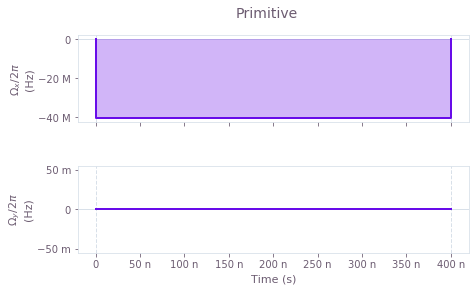

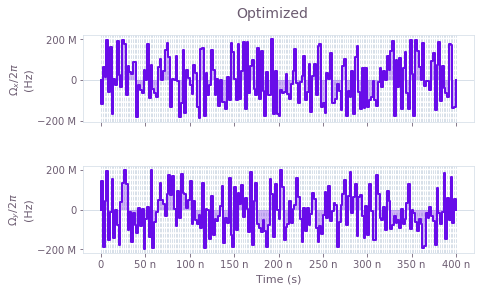

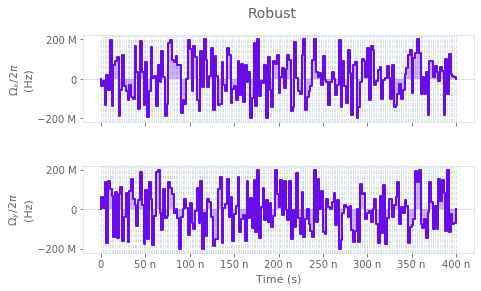

In [7]:
# Primitive
omega_1x_primitive = [
    {"duration": d["duration"] * micro, "value": d["value"] * Mega}
    for d in result_primitive.output["drive_1x"]
]
omega_1y_primitive = [
    {"duration": d["duration"] * micro, "value": d["value"] * Mega}
    for d in result_primitive.output["drive_1y"]
]

plot_controls(
    plt.figure(),
    {
        "$\\Omega_{x}$": omega_1x_primitive,
        "$\\Omega_{y}$": omega_1y_primitive,
    },
)
plt.suptitle("Primitive", fontsize=14)
plt.show()

# Optimized
omega_1x_optimized = [
    {"duration": d["duration"] * micro, "value": d["value"] * Mega}
    for d in result_optimized.output["drive_1x"]
]
omega_1y_optimized = [
    {"duration": d["duration"] * micro, "value": d["value"] * Mega}
    for d in result_optimized.output["drive_1y"]
]
plot_controls(
    plt.figure(),
    {
        "$\\Omega_{x}$": omega_1x_optimized,
        "$\\Omega_{y}$": omega_1y_optimized,
    },
)
plt.suptitle("Optimized", fontsize=14)
plt.show()

# Robust
omega_1x_robust = [
    {"duration": d["duration"] * micro, "value": d["value"] * Mega}
    for d in result_robust.output["drive_1x"]
]
omega_1y_robust = [
    {"duration": d["duration"] * micro, "value": d["value"] * Mega}
    for d in result_robust.output["drive_1y"]
]
plot_controls(
    plt.figure(),
    {
        "$\\Omega_{x}$": omega_1x_robust,
        "$\\Omega_{y}$": omega_1y_robust,
    },
)
plt.suptitle("Robust", fontsize=14)
plt.show()

The above plots display the control pulses ($\Omega_x$ and $\Omega_y$) for the primitive, optimized and robust schemes, respectively.

## Verifying accuracy and robustness of Q-CTRL cross resonance gate

Use the controls obtained above to calculate the exact time evolution determined by the Hamiltonian in the four-level approximation. In the cell below, the evolution dynamics is calculated for each scheme with a batch of crosstalk amplitudes. You can then extract both the noise-free and the noisy dynamics from the result.

First, verify the noise-free operations: compare the noise-free operational infidelities and examine the evolution of an equal superposition of the four lowest 2-qubit states, $|\psi_0\rangle =\frac{1}{2}\left(|00\rangle-i|01\rangle+i|10\rangle+|11\rangle\right)$.

In [8]:
schemes_results = {
    "Primitive": result_primitive,
    "Optimized": result_optimized,
    "Robust": result_robust,
}
initial_state = (np.array([[1, -1j, 1j, 0, 1, 0, 0, 0, 0, 0]]) / 2).T
crosstalks_count = 101
crosstalk_array = np.linspace(-1, 1, crosstalks_count)
infidelities = []
probabilities = []

for scheme in gate_schemes:

    with qctrl.create_graph() as graph:

        # Construct drive terms
        drive_1x_values = np.array(
            [d["value"] for d in schemes_results[scheme].output["drive_1x"]]
        )
        drive_1y_values = np.array(
            [d["value"] for d in schemes_results[scheme].output["drive_1y"]]
        )
        drive_1x = qctrl.operations.pwc_signal(
            values=np.repeat(drive_1x_values[None], crosstalks_count, axis=0),
            duration=duration,
        )
        drive_1y = qctrl.operations.pwc_signal(
            values=np.repeat(drive_1y_values[None], crosstalks_count, axis=0),
            duration=duration,
        )
        drive_1x_term = qctrl.operations.pwc_operator(
            signal=drive_1x, operator=drive_1x_operator
        )
        drive_1y_term = qctrl.operations.pwc_operator(
            signal=drive_1y, operator=drive_1y_operator
        )

        # Construct crosstalk terms
        drive_1x_batched = qctrl.operations.pwc_signal(
            values=drive_1x_values * crosstalk_array[:, None], duration=duration
        )
        drive_1y_batched = qctrl.operations.pwc_signal(
            values=drive_1y_values * crosstalk_array[:, None], duration=duration
        )
        crosstalk_1x = qctrl.operations.pwc_operator(
            signal=drive_1x_batched, operator=crosstalk_constant * drive_2x_operator
        )
        crosstalk_1y = qctrl.operations.pwc_operator(
            signal=drive_1y_batched, operator=crosstalk_constant * drive_2y_operator
        )

        # Construct remaining Hamiltonian terms
        fixed_frequency_1_term = qctrl.operations.constant_pwc_operator(
            operator=np.repeat(
                ((Delta - delta_1 / 2 + epsilon) * n1[:, perm_trunc][perm_trunc, :])[
                    None
                ],
                crosstalks_count,
                axis=0,
            ),
            duration=duration,
        )
        fixed_frequency_2_term = qctrl.operations.constant_pwc_operator(
            operator=np.repeat(
                ((-delta_2 / 2 + epsilon) * n2[:, perm_trunc][perm_trunc, :])[None],
                crosstalks_count,
                axis=0,
            ),
            duration=duration,
        )
        fixed_anharmonicity_1_term = qctrl.operations.constant_pwc_operator(
            operator=np.repeat(
                (delta_1 * np.matmul(n1, n1)[:, perm_trunc][perm_trunc, :] / 2)[None],
                crosstalks_count,
                axis=0,
            ),
            duration=duration,
        )
        fixed_anharmonicity_2_term = qctrl.operations.constant_pwc_operator(
            operator=np.repeat(
                (delta_2 * np.matmul(n2, n2)[:, perm_trunc][perm_trunc, :] / 2)[None],
                crosstalks_count,
                axis=0,
            ),
            duration=duration,
        )
        fixed_coupling_term = qctrl.operations.constant_pwc_operator(
            operator=np.repeat(
                (
                    g
                    * (np.kron(b.T.conj(), b) + np.kron(b, b.T.conj()))[:, perm_trunc][
                        perm_trunc, :
                    ]
                )[None],
                crosstalks_count,
                axis=0,
            ),
            duration=duration,
        )

        # Generate Hamiltonian and evolution operator
        hamiltonian = qctrl.operations.pwc_sum(
            [
                drive_1x_term,
                drive_1y_term,
                crosstalk_1x,
                crosstalk_1y,
                fixed_frequency_1_term,
                fixed_frequency_2_term,
                fixed_anharmonicity_1_term,
                fixed_anharmonicity_2_term,
                fixed_coupling_term,
            ]
        )
        u_H = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=np.array([duration]),
        )

        # Construct phase correction terms
        phase_shift_hamiltonian = qctrl.operations.constant_pwc_operator(
            1.0,
            schemes_results[scheme].output["phase1"][0]["value"] * phase_shift_operator1
            + schemes_results[scheme].output["phase2"][0]["value"]
            * phase_shift_operator2,
        )
        u_phase = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=phase_shift_hamiltonian,
            sample_times=np.array([1.0]),
        )

        # Obtain infidelity
        target_operator_with_phase_shift = qctrl.operations.target(
            operator=qctrl.operations.matmul(u_phase[0], zx_half)
        )
        infidelity_with_phase_shift = qctrl.operations.infidelity_pwc(
            hamiltonian=hamiltonian,
            noise_operators=[],
            target_operator=target_operator_with_phase_shift,
            name="infidelity",
        )

        # Obtain noise-free state evolution
        final_unitary = qctrl.operations.matmul(
            qctrl.operations.conjugate(u_phase),
            u_H,
        )
        final_state = qctrl.operations.matmul(
            final_unitary[int(crosstalks_count / 2), 0],
            initial_state,
            name="final_state",
        )

    # Calculate simulation
    graph_result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=[
            "infidelity",
            "final_state",
        ],
    )

    infidelities.append(graph_result.output["infidelity"]["value"])
    probabilities.append(np.abs(graph_result.output["final_state"]["value"]).T[0] ** 2)

print("Noise-free operational infidelities")
print("Primitive\t\t Optimized\t\t\t Robust")
print(
    infidelities[0][int(crosstalks_count / 2)],
    "\t",
    infidelities[1][int(crosstalks_count / 2)],
    "\t",
    infidelities[2][int(crosstalks_count / 2)],
)

  0%|          | 0/100 [00:02<?, ?it/s]

Your task calculate_graph is currently in a queue waiting to be processed.


  0%|          | 0/100 [00:04<?, ?it/s]

Your task calculate_graph has started.


100%|██████████| 100/100 [00:08<00:00, 11.57it/s]

Noise-free operational infidelities
Primitive		 Optimized			 Robust
0.11344913090646003 	 5.03582928579327e-07 	 2.52207268292004e-07


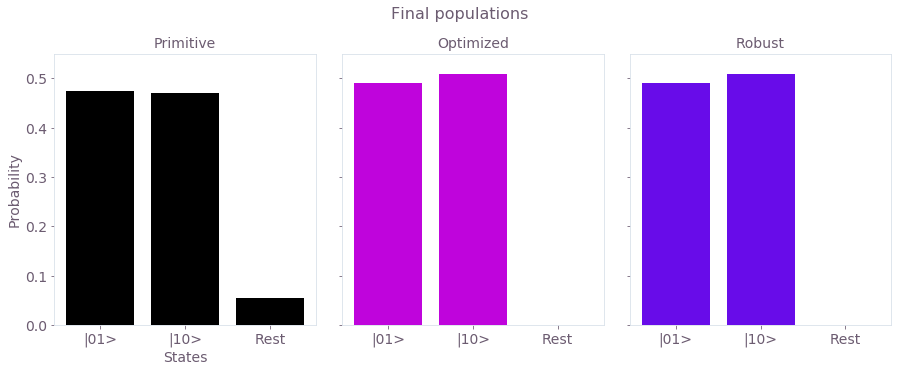

In [9]:
gs = gridspec.GridSpec(1, 3, wspace=0.1)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(3.0 * 5)
fig.suptitle("Final populations", fontsize=16, y=1.01)

ax = fig.add_subplot(gs[0])
ax.tick_params(labelsize=14)
langs = ["|01>", "|10>", "Rest"]
population_primitive = [
    probabilities[0][1],
    probabilities[0][2],
    1 - probabilities[0][1] - probabilities[0][2],
]
ax.bar(langs, population_primitive, color=colors["Primitive"])
ax.set_ylim(0.0, 0.55)
ax.set_title("Primitive", fontsize=14)
ax.set_xlabel("States", fontsize=14)
ax.set_ylabel("Probability", fontsize=14)

ax = fig.add_subplot(gs[1])
ax.tick_params(labelsize=14)
population_optimized = [
    probabilities[1][1],
    probabilities[1][2],
    1 - probabilities[1][1] - probabilities[1][2],
]
ax.bar(langs, population_optimized, color=colors["Optimized"])
ax.set_ylim(0.0, 0.55)
ax.yaxis.set_ticklabels([])
ax.set_title("Optimized", fontsize=14)

ax = fig.add_subplot(gs[2])
ax.tick_params(labelsize=14)
population_robust = [
    probabilities[2][1],
    probabilities[2][2],
    1 - probabilities[2][1] - probabilities[2][2],
]
ax.bar(langs, population_robust, color=colors["Robust"])
ax.set_ylim(0.0, 0.55)
ax.yaxis.set_ticklabels([])
ax.set_title("Robust", fontsize=14)

plt.show()

The figure shows the final state after operating the respective gates on the initial state $|\psi_0\rangle =\frac{1}{2}\left(|00\rangle-i|01\rangle+i|10\rangle+|11\rangle\right)$. The final state after an ideal operation of the CR gate should be the Bell-state $|\psi_f\rangle =\frac{1}{2}\left(|01\rangle+|10\rangle\right)$. The populations are displayed to assess each scheme. Clearly, there is non-negligible population leakage in the primitive scheme, while both the Optimized and Robust schemes perform almost perfectly (up to a small asymmetry).

Next, assess the robustness of the different control solutions to crosstalk noise.

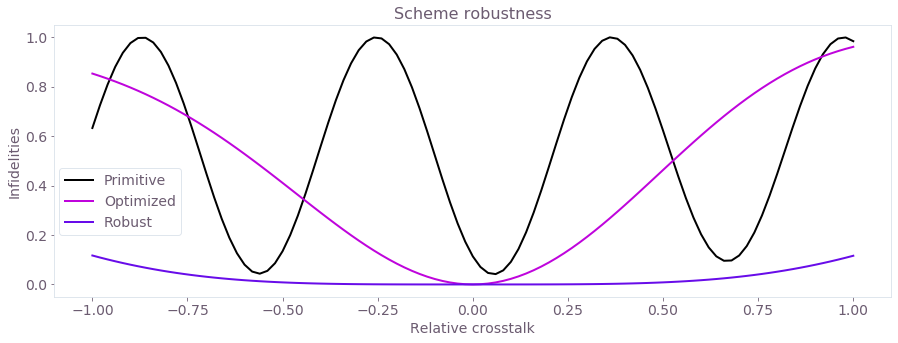

In [10]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.title("Scheme robustness", fontsize=16, y=1)
ax.tick_params(labelsize=14)

for ind, infidelity in enumerate(infidelities):
    name = gate_schemes[ind]
    ax.plot(crosstalk_array, infidelity, label=name, color=colors[name], linewidth=2)
    ax.set_xlabel("Relative crosstalk", fontsize=14)
    ax.set_ylabel("Infidelities", fontsize=14)
    ax.legend(loc="best", bbox_to_anchor=(0.16, 0.5), fontsize=14)
plt.show()

The figure demonstrates the different noise (crosstalk) susceptibilities (in terms of operational infidelity) of the Primitive, Optimized and Robust controls. The Robust scheme has a much broader low-infidelity region.